# scikit-learn での dtreeviz のサンプル

https://github.com/parrt/dtreeviz

決定木の可視化とモデル解釈のための Python ライブラリ。決定木の構造や、決定プロセス、および決定木がどのように特定の予測を行うのかを理解するのに役立つ。

[scikit-learn](https://scikit-learn.org/stable/) の他、[XGBoost](https://xgboost.readthedocs.io/en/latest/), [Spark MLib](https://spark.apache.org/mllib/), [LightGBM](https://lightgbm.readthedocs.io/en/latest/), そして [Tensorflow](https://www.tensorflow.org/decision_forests?hl=ja) をサポートしている。

分類タスクと回帰タスクの両方の決定木に対応しており、それぞれに適した可視化をしてくれる。scikit-learn であれば、

- `DecisionTreeClassifier`
- `DecisionTreeRegressor`

の２つを dtreeviz で可視化できる。scikit-learn のその他の決定木ベースのモデルは、内部で複数の決定木をもつアンサンブル学習器であり、決定木の実装として上の２つの１つを使う。

- `RandomForestClassifier`

は `DecisionTreeClassifier` を使い、

- `RandomForestRegressor`
- `GradientBoostingClassifier`
- `GradientBoostingRegressor`

は、`DecisionTreeRegressor` を使う。これらのアンサンブル学習器を dtreeviz で可視化するときはアンサンブル学習器全体を可視化することはできず、内部の決定木の１つを選んで可視化しなければならない。また、`GradientBoostingClassifier` は分類器だが、勾配ブースティングアルゴリズムを利用しているので決定木として分類ツリーではなく回帰ツリーを使っている。

サンプルデータセットとして、タイタニックのデータセットを使い、`DecisionTreeClassifier` と `DecisionTreeRegressor` を可視化してみる。



## Setup

In [1]:
import sys
import os

import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.model_selection import train_test_split

import dtreeviz

random_state = 42

import matplotlib.pyplot as plt

/Users/kazu/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load Sample Data

In [2]:
dataset_url = "https://raw.githubusercontent.com/parrt/dtreeviz/master/data/titanic/titanic.csv"
dataset = pd.read_csv(dataset_url)

dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
# Fill missing values for Age
# Age 列の欠損値を Age 列の平均値で置換する。
dataset.fillna({"Age":dataset.Age.mean()}, inplace=True)

# Encode categorical variables
# Sex,Cabin, Embarked 列を数値に変換する。
dataset["Sex_label"] = dataset.Sex.astype("category").cat.codes
dataset["Cabin_label"] = dataset.Cabin.astype("category").cat.codes
dataset["Embarked_label"] = dataset.Embarked.astype("category").cat.codes

dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_label,Cabin_label,Embarked_label
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,1,-1,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,0,81,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,0,-1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,0,55,2
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,1,-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,1,-1,2
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,0,30,2
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S,0,-1,2
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,1,60,0


## Classifiers

分類タスクを実行するために、データセットから 6個の特徴量

- `Pclass` （乗客クラス）。`1`, `2`, `3` があり、`1` が最上級。
- `Age` （年齢）
- `Fare` （運賃）
- `Sex_label` （性別）。`1` が男性、`0` が女性。
- `Cabin_label` （客室番号）。本来はアルファベットで始まり、数字が続く文字列だが、数値に変換済み。`-1` は欠損値に対応。
- `Embarked_label` （乗客が乗船した港）。アルファベットだが、数値に変換済み。

目的変数は、`Survived` であり、`1` （生存）、`0` （死亡） を予測する。

`DecisionTreeClassifier` を作成し、訓練する。

In [4]:
features = ["Pclass", "Age", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]
target = "Survived"

tree_classifier = DecisionTreeClassifier(max_depth=3, random_state=random_state)
tree_classifier.fit(dataset[features].values, dataset[target].values)

DecisionTreeClassifier(max_depth=3, random_state=42)

### Initialize dtreeviz model (adaptor)

Adaptor を使って、特定のモデル実装を dtreeviz に Adapt させる。ここでも `DecisionTreeClassifier` を Adapt する。いったん Adapt してしまえば、任意の決定木ベースのモデルを共通のインターフェースで可視化できる。

`model()` 関数には、対象とするモデルと、訓練に使用したデータ `X`, `y`, および特徴量名と目的変数名、そして各クラス変数名を渡す。訓練データを渡すことで、それらも可視化に利用する。

In [5]:
viz_model = dtreeviz.model(tree_classifier,
                                  X_train=dataset[features],
                                  y_train=dataset[target],
                                  feature_names=features,
                                  target_name=target,
                                  class_names=["perish", "survive"])

### Tree structure visualizations

ここではツリー構造を可視化する。まず、比較のために最初に graphviz で可視化してみる。

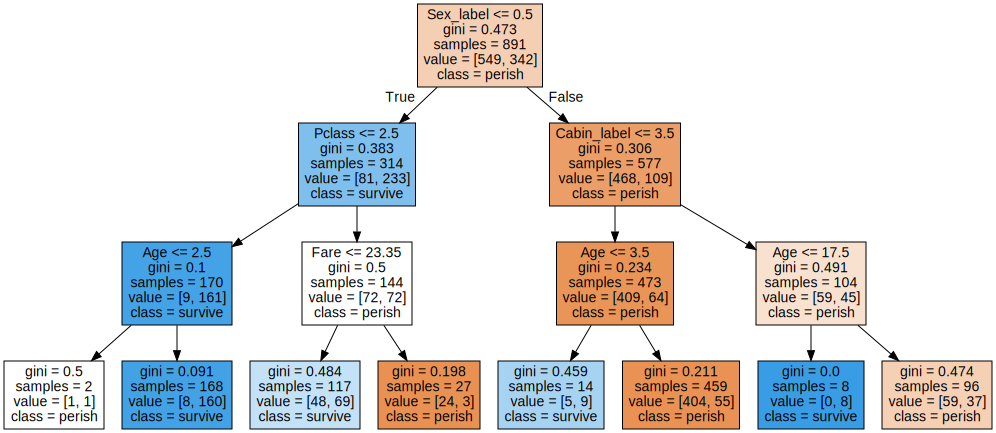

In [6]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(
    tree_classifier,
    out_file=None,
    feature_names=features,
    class_names=["perish", "survive"],
    filled=True)

graph = graphviz.Source(dot_data)
graph

次に dtreeviz で同じツリーがどのように可視化されるかを確認する。視覚情報がより多くなっており、訓練データの分布状況のヒストグラムなど、graphviz では得られなかった情報も可視化される。

`view` メソッドで可視化するが、オプション引数により可視化方法や表示する情報をカスタマイズできる。

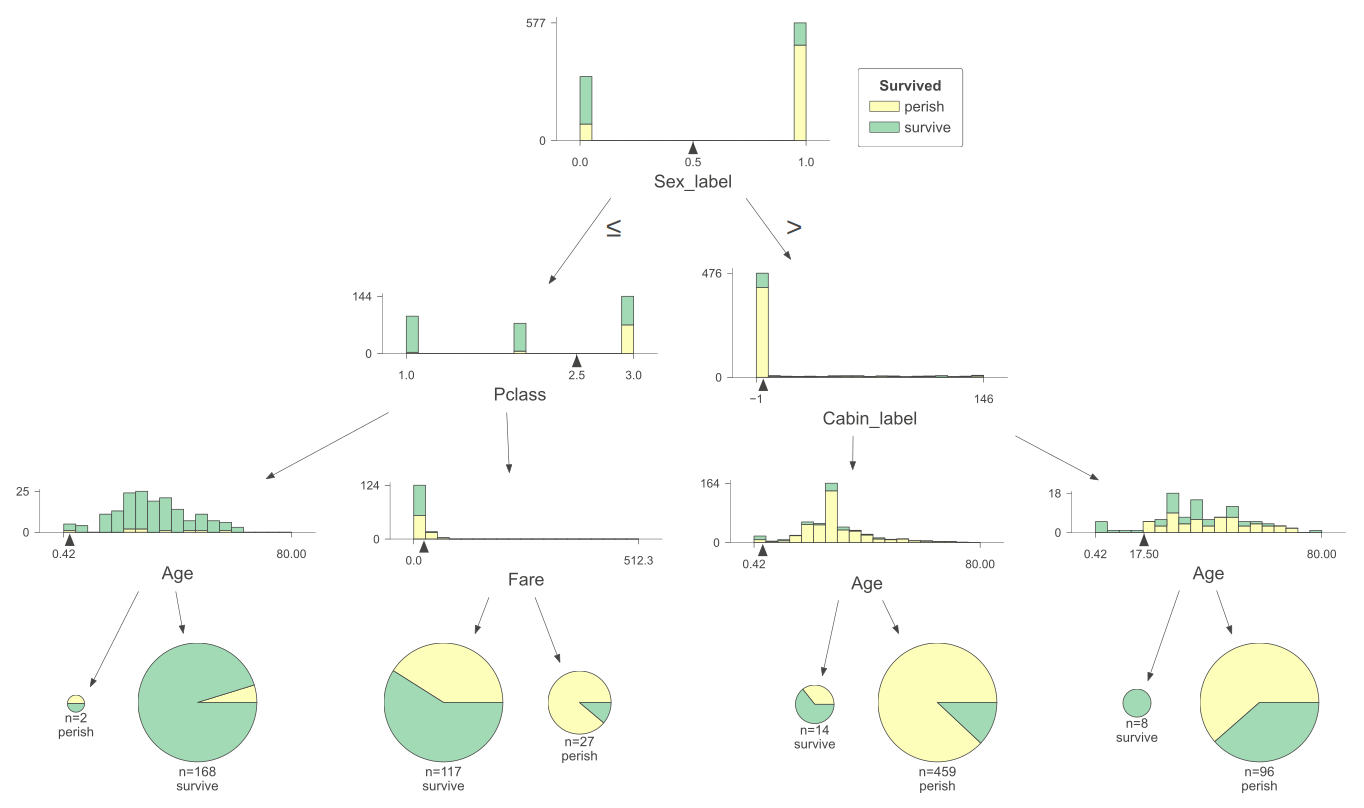

In [7]:
# scale 引数でサイズを指定できる。
viz_model.view(scale=2)

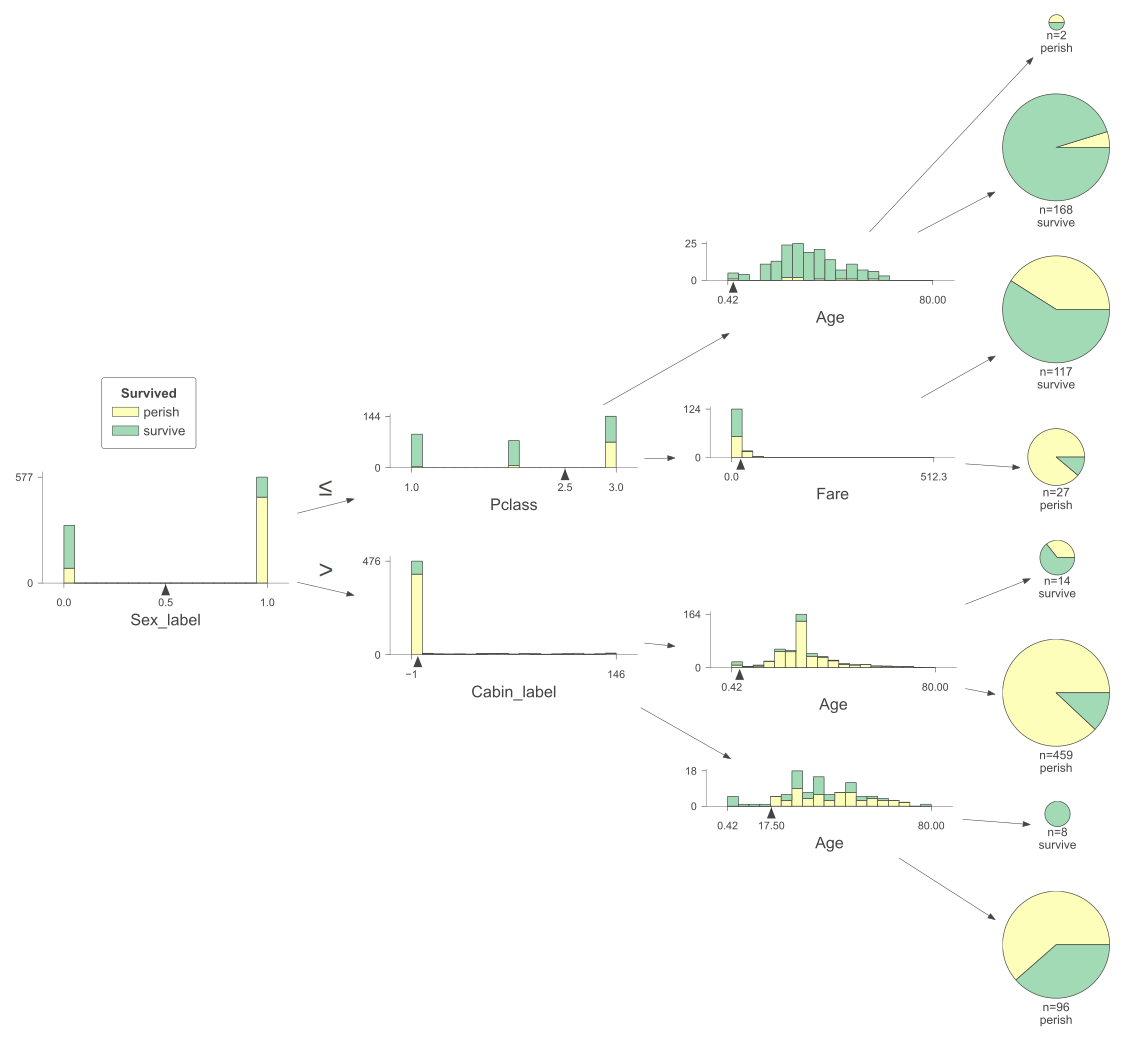

In [8]:
# 横向きにしたいなら、orientation 引数を使う。
viz_model.view(scale=1.8, orientation="LR")

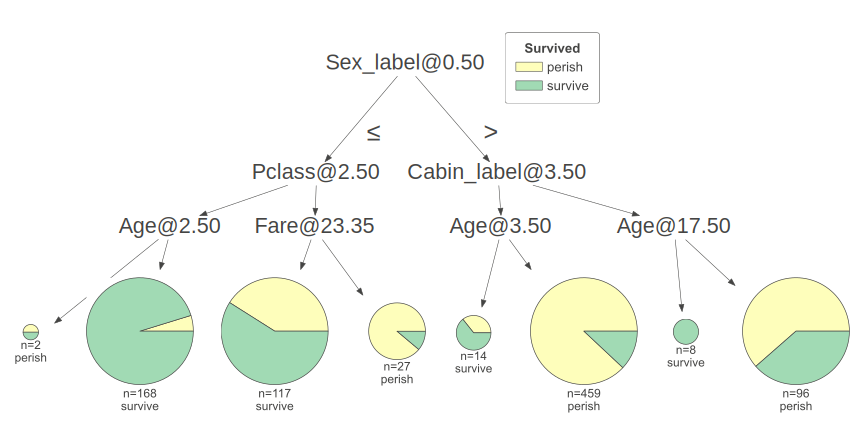

In [9]:
# fancy=False とすると装飾なしのシンプルな可視化になる。
viz_model.view(scale=1.8, fancy=False)

ツリーの深さを限定して可視化することもできる。深さ 0 がツリーのルートになる。

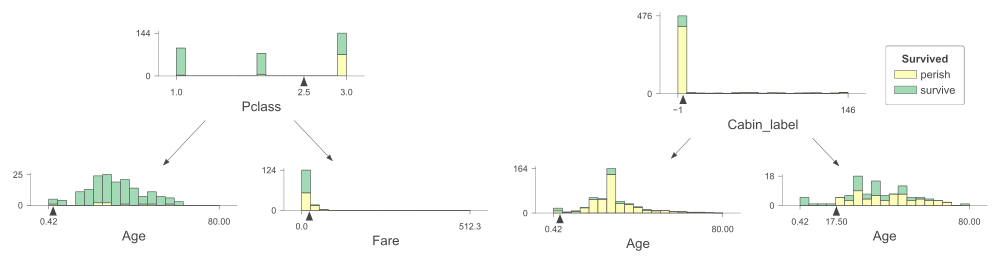

In [10]:
# ツリーの深さ １ から ２ の範囲を可視化する。
viz_model.view(depth_range_to_display=(1, 2), scale=1.5)

### Prediction path explanations

特定のデータインスタンスを分類する過程で、決定木のルートから Leaf までどのようなパスをたどるのかや、どの特徴量（説明変数）が使用されたのかを確認することもできる。

In [11]:
x = dataset[features].iloc[6]
x

Pclass              1.0000
Age                54.0000
Fare               51.8625
Sex_label           1.0000
Cabin_label       129.0000
Embarked_label      2.0000
Name: 6, dtype: float64

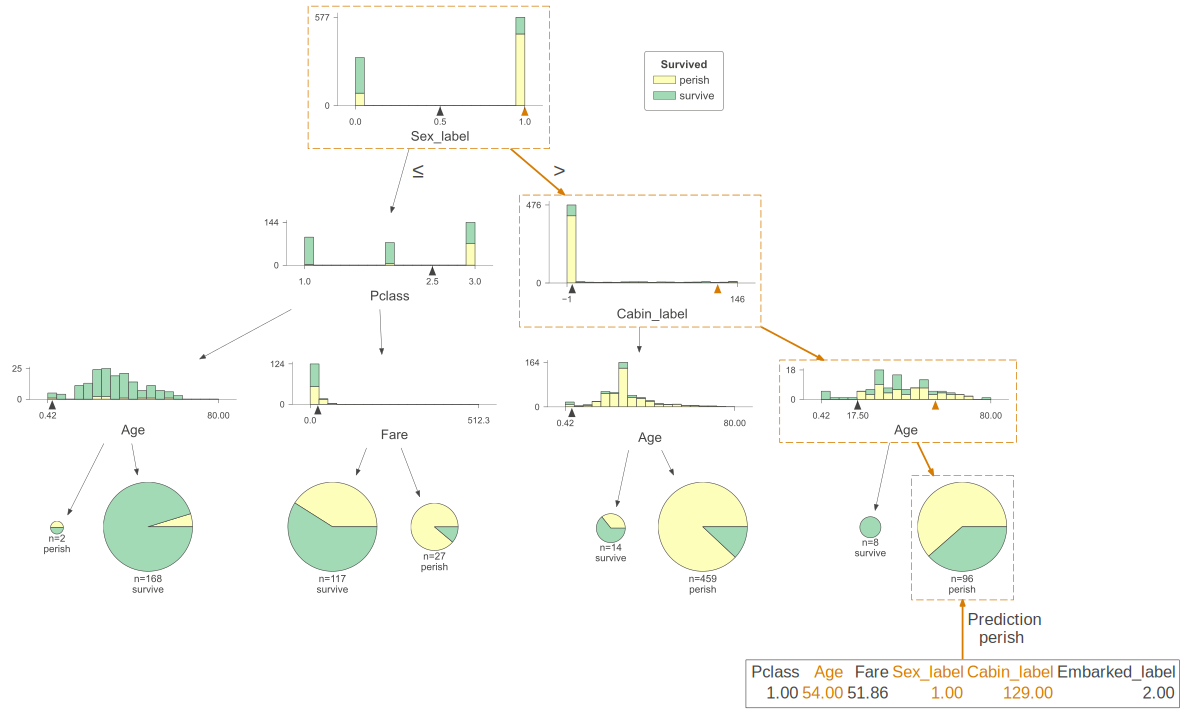

In [12]:
viz_model.view(x=x, scale=1.5)

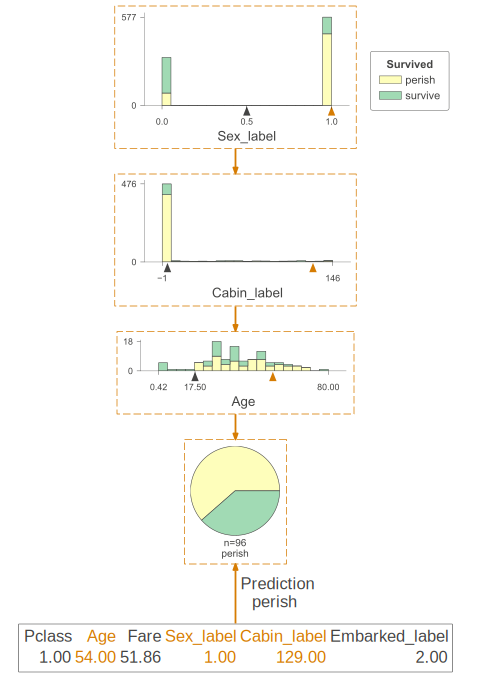

In [13]:
# show_just_path=True にすると、ツリー中で経由したノードのみを表示させることができる。
viz_model.view(x=x, scale=1.5, show_just_path=True)

`explain_prediction_path` メソッドで、特定のインスタンスが決定木を通過するときのパス情報を文字列で取得できる。

In [14]:
print(
    viz_model.explain_prediction_path(x)
)

17.5 <= Age 
0.5 <= Sex_label 
3.5 <= Cabin_label 



`instance_feature_importance` メソッドを使うと、特定のインスタンスに対する予測に寄与した特徴量の重要度を可視化できる。


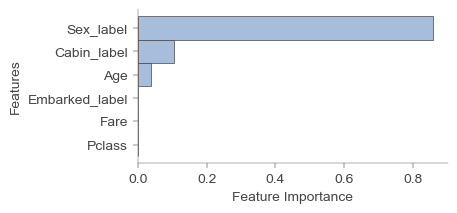

In [15]:
viz_model.instance_feature_importance(x, figsize=(4,2))

特定のインスタンスではなく、モデル全体での特徴量重要度は、scikit-learn の決定木ベースのモデルでは、`feature_importances_` 属性がもっている。

これは、訓練時の決定木の分割の際のジニ不純度やエントロピーの減少にもとづいて計算されている。一応、これについても確認し、可視化してみる。

In [16]:
features, tree_classifier.feature_importances_

(['Pclass', 'Age', 'Fare', 'Sex_label', 'Cabin_label', 'Embarked_label'],
 array([0.16018814, 0.07104168, 0.0516667 , 0.63958982, 0.07751366,
        0.        ]))

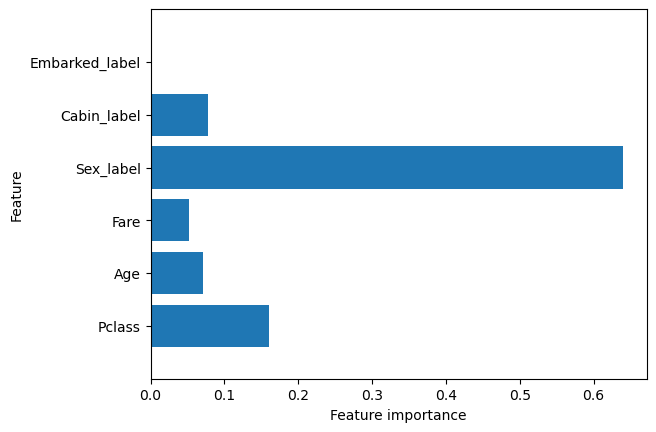

In [17]:
def plot_feature_importances(feature_importances, feature_names):
    n_features = len(feature_names)
    plt.barh(np.arange(n_features), feature_importances, align='center')
    plt.yticks(np.arange(n_features), features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(tree_classifier.feature_importances_, features)

決定木ベースのモデルに限らず、機械学習モデルの特徴量の重要度は、**PFI** の手法で計算でき、scikit-learn にも `sklearn.inspection.permutation_importance` 関数として実装されている。

### Leaf Info

決定木の Leaf がもっている情報を取得するためのメソッドがいくつかある。まず、今使用している `DecisionTreeClassifier` モデルがもっている Leaf の数を確認しておこう。

In [18]:
tree_classifier.get_n_leaves()

8

`leaf_sizes` メソッドで、各 Leaf ノードがもっているサンプル数を可視化できる。

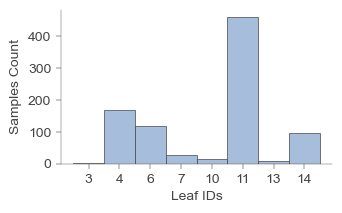

In [19]:
viz_model.leaf_sizes(figsize=(3.5,2))

なお、Leaf ID がこのような不連続な値になっているのは、scikit-learn の決定木では、ルートノードの ID を ０ とし、深さ優先で他のノードの ID が決められるため。

`ctree_leaf_distributions` メソッドで、各 Leaf のサンプルのクラス分布を可視化できる。

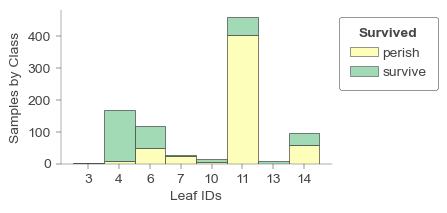

In [20]:
viz_model.ctree_leaf_distributions(figsize=(3.5,2))

`node_stats` メソッドで、指定したノードがもっているサンプルの統計情報を出力できる。

In [21]:
# ルートノード（node_id=0）におけるサンプルの統計情報
# つまり、訓練データ全体での統計情報
viz_model.node_stats(node_id=0)

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label
count,891.0,891.0,891.0,891.0,891.0,891.0
mean,2.308642,29.699118,32.204208,0.647587,16.62963,1.529742
std,0.836071,13.002015,49.693429,0.47799,38.140335,0.800254
min,1.0,0.42,0.0,0.0,-1.0,-1.0
25%,2.0,22.0,7.9104,0.0,-1.0,1.0
50%,3.0,29.699118,14.4542,1.0,-1.0,2.0
75%,3.0,35.0,31.0,1.0,-1.0,2.0
max,3.0,80.0,512.3292,1.0,146.0,2.0


In [22]:
# ノード（node_id=14）におけるサンプルの統計情報
# これはもっとも右側にある Leaf ノードだ。
viz_model.node_stats(node_id=14)

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label
count,96.0,96.0,96.0,96.0,96.0,96.0
mean,1.135417,40.301991,66.934377,1.0,73.822917,1.354167
std,0.472837,13.359336,83.865165,0.0,42.18206,0.928827
min,1.0,18.0,0.0,1.0,4.0,0.0
25%,1.0,29.699118,27.45,1.0,37.5,0.0
50%,1.0,37.0,37.0,1.0,72.5,2.0
75%,1.0,49.0,77.2875,1.0,110.25,2.0
max,3.0,80.0,512.3292,1.0,146.0,2.0


`leaf_purity` メソッドを使うと、各 Leaf ノードのジニ不純度がわかる。

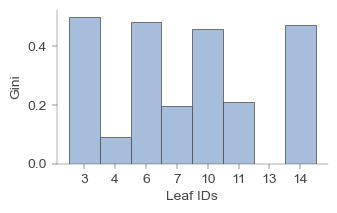

In [23]:
viz_model.leaf_purity(figsize=(3.5,2))

Node ID = 13 の Leaf はジニ不純度が ０ になってる。これは、この Leaf がもっているサンプルのすべてが `survive` であり、純度 １００％ だからだ。

## Regressors